# SVD-only Article Clustering

This notebook clusters H&M articles using only SVD (LSA) embeddings derived from TF‑IDF of product descriptions.

- Loads dense SVD vectors (no categorical features)
- Selects k via the elbow method
- Performs clustering and interpretation using product metadata
- Visualises clusters with PCA and t‑SNE

All identifiers, comments, and Markdown use UK spellings.


In [1]:
# Imports and configuration
import sys
sys.path.append('../') 
import os
import polars as pl
import numpy as np

from hnm_data_analysis.clustering.article_clustering import ArticleClusterer, ClusteringConfig

# Set absolute project paths
BASE_DIR = "/Users/tom/Data Analysis Projects/h_and_m_data_analysis"
FEATURES_DIR = f"{BASE_DIR}/data/processed/features"
SVD_PATH = f"{FEATURES_DIR}/svd_embeddings.parquet"
ARTICLE_ID_INDEX = f"{FEATURES_DIR}/article_id_index.csv"
ARTICLES_PATH = f"{BASE_DIR}/data/cleaned/articles_last_3_months_cleaned.parquet"
RESULTS_DIR = f"{BASE_DIR}/results/svd_clustering"

os.makedirs(RESULTS_DIR, exist_ok=True)
print("Base directory:", BASE_DIR)


Base directory: /Users/tom/Data Analysis Projects/h_and_m_data_analysis


In [2]:
# 1) Load SVD embeddings and align article IDs
svd_df = pl.read_parquet(SVD_PATH)
print("SVD shape:", svd_df.shape)

# Ensure article_id column exists
assert "article_id" in svd_df.columns, "svd_embeddings.parquet must include 'article_id'"

# Sort by article_id to align deterministically
svd_df = svd_df.sort("article_id")

# Extract features (columns starting with 'svd_')
svd_cols = [c for c in svd_df.columns if c.startswith("svd_")]
X = svd_df.select(svd_cols).to_numpy()
article_ids = svd_df["article_id"].to_list()

print("Feature matrix:", X.shape)
print("Example columns:", svd_cols[:5])


SVD shape: (42229, 201)
Feature matrix: (42229, 200)
Example columns: ['svd_001', 'svd_002', 'svd_003', 'svd_004', 'svd_005']


In [3]:
# 2) Persist features in compatible format for clusterer
features_npy = f"{FEATURES_DIR}/svd_only_features.npy"
ids_csv = f"{FEATURES_DIR}/svd_only_article_id_index.csv"

np.save(features_npy, X)
pl.DataFrame({"article_id": article_ids}).write_csv(ids_csv)

print("Saved:", features_npy)
print("Saved:", ids_csv)


Saved: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/data/processed/features/svd_only_features.npy
Saved: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/data/processed/features/svd_only_article_id_index.csv


In [4]:
# 3) Cluster using ArticleClusterer on SVD-only features
clusterer = ArticleClusterer(
    features_path=features_npy,
    article_ids_path=ids_csv,
    articles_metadata_path=ARTICLES_PATH
)

clusterer.load_features()
clusterer.load_articles_metadata()

# Find optimal k via elbow
optimal_k, scores = clusterer.find_optimal_k(k_range=(3, 20), algorithm="kmeans")
print("Optimal k:", optimal_k)
print("Elbow scores (inertia):", scores)


Loaded features: 42,229 articles x 200 features
Loaded articles metadata: 42,298 articles
Finding optimal k using elbow method with kmeans...
k=3: elbow score = 37906.0302
k=4: elbow score = 37091.9552
k=5: elbow score = 36384.8496
k=6: elbow score = 35816.8731
k=7: elbow score = 35230.3112
k=8: elbow score = 34772.6311
k=9: elbow score = 34261.0193
k=10: elbow score = 33801.9384
k=11: elbow score = 33304.8869
k=12: elbow score = 32946.3856
k=13: elbow score = 32555.1807
k=14: elbow score = 32225.5960
k=15: elbow score = 31876.4708
k=16: elbow score = 31552.2630
k=17: elbow score = 31248.1549
k=18: elbow score = 30933.6729
k=19: elbow score = 30672.6223
k=20: elbow score = 30498.1761
Optimal k selected: 5
Optimal k: 5
Elbow scores (inertia): {3: 37906.03017525948, 4: 37091.95524757571, 5: 36384.84958822857, 6: 35816.87311737125, 7: 35230.311220804724, 8: 34772.63110722086, 9: 34261.01934897534, 10: 33801.938369192765, 11: 33304.88693983802, 12: 32946.38559119855, 13: 32555.180671521244

In [9]:
# 4) Run K-means clustering and interpret
config = ClusteringConfig(
    algorithm="kmeans",
    n_clusters=3,
    random_state=42
)

results = clusterer.cluster(config)
summaries = clusterer.interpret_clusters()

print("\nCluster summaries (truncated):")
for cid, s in list(summaries.items())[:5]:
    print(f"Cluster {cid}: size={s['size']} ({s['percentage']:.1f}%)")


Performing kmeans clustering...
Clustering completed: 3 clusters
Silhouette Score: 0.0320
Calinski-Harabasz Index: 1066.7708
Davies-Bouldin Index: 5.0502

Cluster summaries (truncated):
Cluster 0: size=11306 (26.8%)
Cluster 1: size=6134 (14.5%)
Cluster 2: size=24789 (58.7%)


Creating 2D visualization using PCA...
Saved cluster visualization to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/svd_clustering/clusters_pca.png


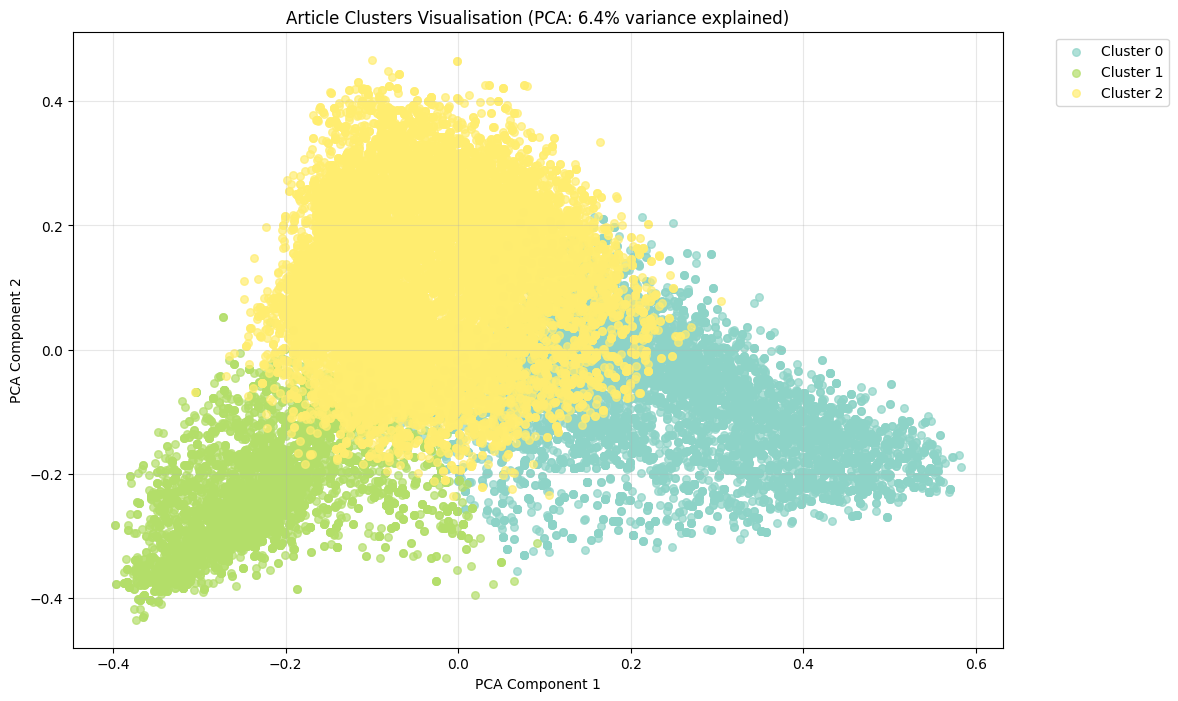

Creating 2D visualization using TSNE...
Saved cluster visualization to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/svd_clustering/clusters_tsne.png


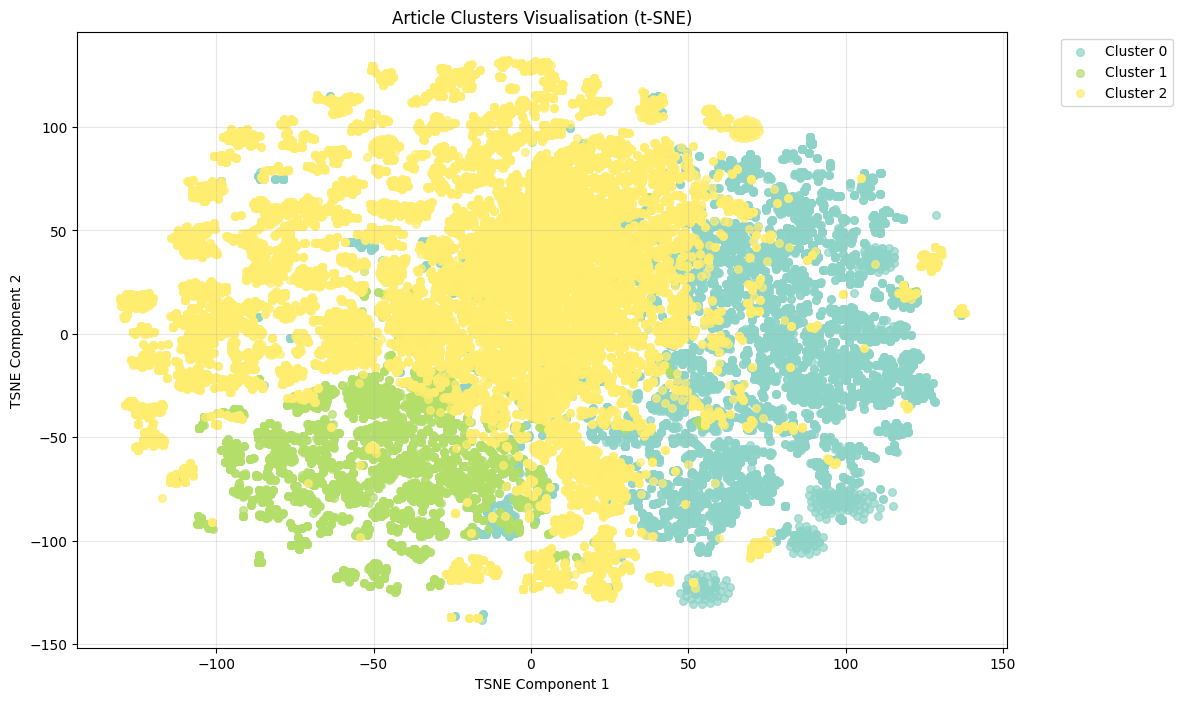

Saved cluster labels to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/svd_clustering/cluster_labels.csv
Saved clustering model to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/svd_clustering/clustering_model.joblib
Saved results metadata to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/svd_clustering/clustering_results.json


TypeError: Object of type Series is not JSON serializable

In [10]:
# 5) Visualisations and save results
clusterer.visualise_clusters(method="pca", save_path=f"{RESULTS_DIR}/clusters_pca.png")
clusterer.visualise_clusters(method="tsne", save_path=f"{RESULTS_DIR}/clusters_tsne.png")

clusterer.save_results(RESULTS_DIR)
print("Saved results to:", RESULTS_DIR)
